In [55]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [56]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Python code is hidden por better reading.
In order to show/hide the code, please click <a href="javascript:code_toggle()">here.</a>.''')

In [57]:
#%config InlineBackend.figure_format = 'svg'

In [58]:

import pandas as pd
import numpy as np
import scipy
import seaborn as sns



from scipy.stats import spearmanr, ranksums, pearsonr, kruskal
import matplotlib.pyplot as plt
from IPython.display import display, HTML


from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold,LeaveOneOut
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix,ConfusionMatrixDisplay
import statsmodels.api as sm



PREPROCESS:
Records with ID 96 and 192 are removed because total units of alcohol (SDU) is negative (UBES_TOTAL_SEMANA)=-1)
First 204 cases are Risk drinkers, and 205-337 are control patients.
Due to a great amount of missing values, we remove features: ['NA', 'ACPROT', 'AMI', 'APTT', 'BD.717', 'BI.717', 'CK', 'COAG_', 'FIBR.C', 'INR_', 'PCR']
Además NA es repetida con Sodio


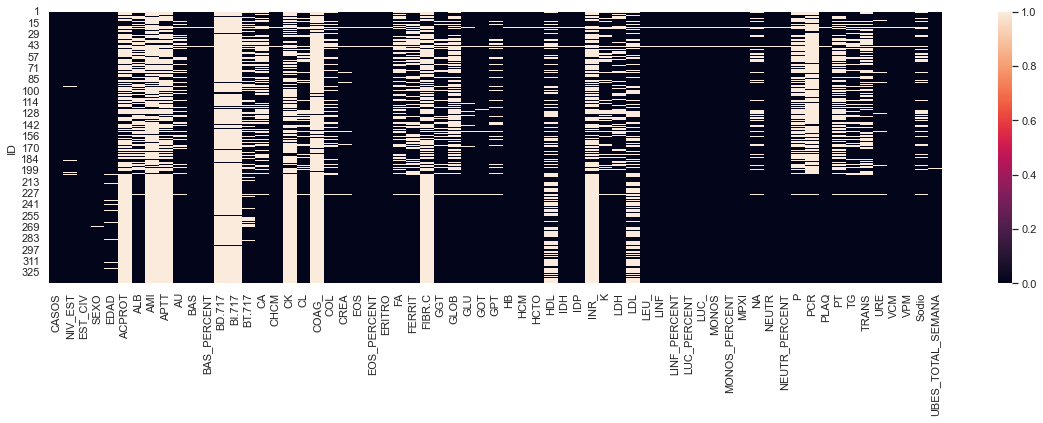

We keep:  Index(['CASOS', 'NIV_EST', 'EST_CIV', 'SEXO', 'EDAD', 'ALB', 'AU', 'BAS',
       'BAS_PERCENT', 'BT.717', 'CA', 'CHCM', 'CL', 'COL', 'CREA', 'EOS',
       'EOS_PERCENT', 'ERITRO', 'FA', 'FERRIT', 'GGT', 'GLOB', 'GLU', 'GOT',
       'GPT', 'HB', 'HCM', 'HCTO', 'HDL', 'IDH', 'IDP', 'K', 'LDH', 'LDL',
       'LEU_', 'LINF', 'LINF_PERCENT', 'LUC_PERCENT', 'LUC_', 'MONOS',
       'MONOS_PERCENT', 'MPXI', 'NEUTR', 'NEUTR_PERCENT', 'P', 'PLAQ', 'PT',
       'TG', 'TRANS', 'URE', 'VCM', 'VPM', 'Sodio', 'UBES_TOTAL_SEMANA'],
      dtype='object')


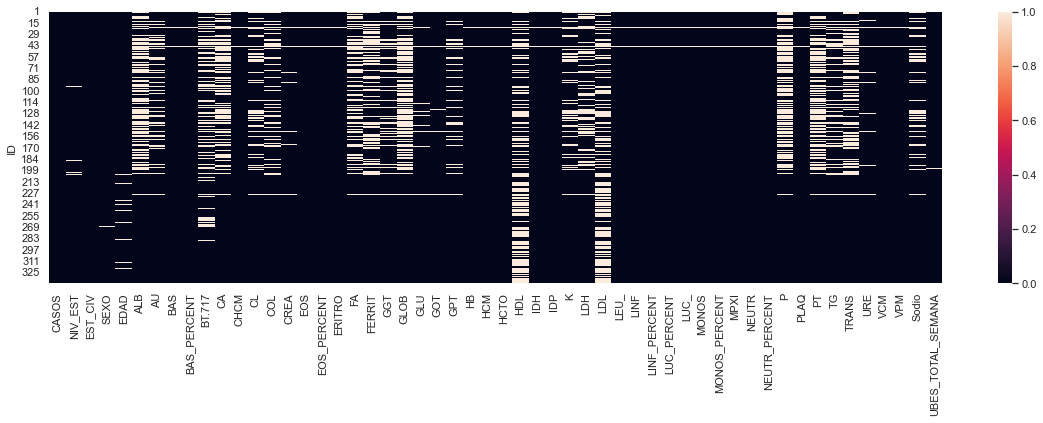

Control patients without SDU standard drink units per week ('UBES_TOTAL_SEMANA') are set to 0.
We create feature 'Bebedor_Riesgo' (Risk drink user) based on these rules:
	Man: if he drinks >=28 UBEs/week.
	Woman: if she drinks >=17 UBEs/week.
As a consequence, some cases do not belong to their origin.
Patients coming from UCA (Adictive behaviour unit) tagged as Risk ('Riesgo') (1):
1    173
0     29
Name: Bebedor_Riesgo, dtype: int64
Int64Index([  8,  16,  19,  20,  23,  34,  39,  43,  48,  53,  61,  62,  65,
             66,  74,  76,  87,  92, 116, 124, 128, 131, 147, 164, 165, 176,
            184, 189, 196],
           dtype='int64', name='ID')
Controles categorizados como Riesgo (1)
0    133
Name: Bebedor_Riesgo, dtype: int64
Int64Index([], dtype='int64', name='ID')
Index(['CASOS', 'NIV_EST', 'EST_CIV', 'SEXO', 'EDAD', 'ALB', 'AU', 'BAS',
       'BAS_PERCENT', 'BT.717', 'CA', 'CHCM', 'CL', 'COL', 'CREA', 'EOS',
       'EOS_PERCENT', 'ERITRO', 'FA', 'FERRIT', 'GGT', 'GLOB', 'GLU', 

In [59]:
print("PREPROCESS:")
df = pd.read_excel('alcohol_use_ddbb.xls',index_col=0)
df = df.rename(columns={'UBES_TOTAL': 'UBES_TOTAL_SEMANA'})
df = df[['CASOS','NIV_EST','EST_CIV','SEXO','EDAD','ACPROT','ALB','AMI','APTT','AU','BAS','BAS_PERCENT','BD.717','BI.717','BT.717','CA','CHCM','CK','CL','COAG_','COL','CREA','EOS','EOS_PERCENT','ERITRO','FA','FERRIT','FIBR.C','GGT','GLOB','GLU','GOT','GPT','HB','HCM','HCTO','HDL','IDH','IDP','INR_','K','LDH','LDL','LEU_','LINF','LINF_PERCENT','LUC_PERCENT','LUC_','MONOS','MONOS_PERCENT','MPXI','NA','NEUTR','NEUTR_PERCENT','P','PCR','PLAQ','PT','TG','TRANS','URE','VCM','VPM','Sodio','UBES_TOTAL_SEMANA']]


print("Records with ID 96 and 192 are removed because total units of alcohol (SDU) is negative (UBES_TOTAL_SEMANA)=-1)")
df=df.drop([96,192], axis=0)

v_remove=['NA','ACPROT', 'AMI','APTT','BD.717','BI.717','CK','COAG_','FIBR.C','INR_','PCR']
print("First 204 cases are Risk drinkers, and 205-337 are control patients.")
print("Due to a great amount of missing values, we remove features:", v_remove)
print("Además NA es repetida con Sodio")
plt.rcParams["figure.figsize"] = (20,5)
sns.heatmap(df.isnull())
df = df.drop(v_remove,axis=1)
plt.show()
print("We keep: ",df.columns)
sns.heatmap(df.isnull())
plt.show()

print("Control patients without SDU standard drink units per week ('UBES_TOTAL_SEMANA') are set to 0.")
df['UBES_TOTAL_SEMANA'].fillna(0, inplace=True)

print('We create feature \'Bebedor_Riesgo\' (Risk drink user) based on these rules:')
print('\tMan: if he drinks >=28 UBEs/week.')
print('\tWoman: if she drinks >=17 UBEs/week.')
print('As a consequence, some cases do not belong to their origin.')
df['Bebedor_Riesgo'] = np.where( ((df['SEXO'] == 1) & (df['UBES_TOTAL_SEMANA'] >= 28)) |
                                 ((df['SEXO'] == 2) & (df['UBES_TOTAL_SEMANA'] >= 17)), 1, 0)

print("Patients coming from UCA (Adictive behaviour unit) tagged as Risk ('Riesgo') (1):")
print(df[df['CASOS']==1]['Bebedor_Riesgo'].value_counts())
print(df[(df['CASOS']==1) & (df['Bebedor_Riesgo']==0)].index)
print("Controles categorizados como Riesgo (1)")
print(df[df['CASOS']==0]['Bebedor_Riesgo'].value_counts())
print(df[(df['CASOS']==0) & (df['Bebedor_Riesgo']==1)].index)


df.to_csv("alcohol_use_ddbb.csv")

v_analytics=['ACPROT','ALB','AMI','APTT','AU','BAS','BAS_PERCENT','BD.717','BI.717','BT.717','CA','CHCM',
              'CK','CL','COAG_','COL','CREA','EOS','EOS_PERCENT','ERITRO','FA','FERRIT','FIBR.C','GGT','GLOB',
              'GLU','GOT','GPT','HB','HCM','HCTO','HDL','IDH','IDP','INR_','K','LDH','LDL','LEU_','LINF',
              'LINF_PERCENT','LUC_PERCENT','LUC_','MONOS','MONOS_PERCENT','MPXI','NA','NEUTR','NEUTR_PERCENT',
              'P','PCR','PLAQ','PT','TG','TRANS','URE','VCM','VPM','Sodio']
v_analytics = [v for v in v_analytics if not v in v_remove]


v_analytics=['ALB','UA','BAS','BAS_PERCENT','TBIL','CA','MCHC','CL','CHOL','CREA','EOS','EOS_PERCENT','RBC','ALP','FERRIT','GGT','GLOB','GLU','AST','ALT','HB','MCH','HCT','HDL','RDW','PDW','K','LDH','LDL','WBC','LYM','LYM_PERCENT','LUC_PERCENT','LUC_','MONOS','MONOS_PERCENT','MPO','NEUTR','NEUTR_PERCENT','P','PLAT','TP','TG','Tf','UREA','MCV','MPV','Sodium']
print(df.columns,len(df.columns))
print("Change feature names to english.")
df.columns=['CASES','STUDY_LEVEL','MARITAL_STATUS','SEX','AGE']+v_analytics+['WEEKLY_SDU','Alcohol Risk']
print(df.columns,len(df.columns))





As we can see, we have 29 patitens which are not tagged as risk drinkers. And 0 control patients tagged as risk drinkers.


## 1. Correlation of analytical features with SDU ('UBE').
### 1.A with numeric version of SDU/week

In [60]:
#Pearson test
def grafico_pearson(data, variables, var_target, y_label):
    # param data: dataframe
    # param variables: list of variables names in dataframe to compute their corr with target
    # param target: target variable name
    
    target=data[var_target].values
    X=data[variables].values
    corr=list()
    p_values=list()
    for column in X.T:
        keep=~np.isnan(column)
        column = column[keep]
        target_without_nan=target[keep]
        (c,p)=pearsonr(column,target_without_nan)
        corr = corr + [c]
        p_values = p_values + [p]
    
    #plot
    sns.set(style="whitegrid")
    colors = ['Red' if _y >=0.5 else 'Orange' for _y in corr]
    ax=sns.barplot(y=variables,x=corr,palette=colors,orient = 'h')
    ax.set(xlim=(-0.7,0.7))
    ax.set_xlabel(xlabel='Pearson\'s correlation coefficient ([-1,1]) and p-value.',fontsize=60)
    ax.set_ylabel(ylabel=y_label,fontsize=60)
    ax.set_yticklabels(labels=variables,fontsize=40)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(40) 
    #ax.set_xticklabels(labels=[-0.6,-0.4,-0.2,0,0.2,0.4,0.6],fontsize=40)
    plt.rcParams["figure.figsize"] = (40,80)
     
    
    #add p-values text
    positions=list()
    for bar in ax.patches:
        positions=positions+ [bar.get_y()]
    
    for i in range(len(positions)):
        ax.text(corr[i]+0.01,positions[i]+0.6,format(p_values[i],'.1E'),size=30)


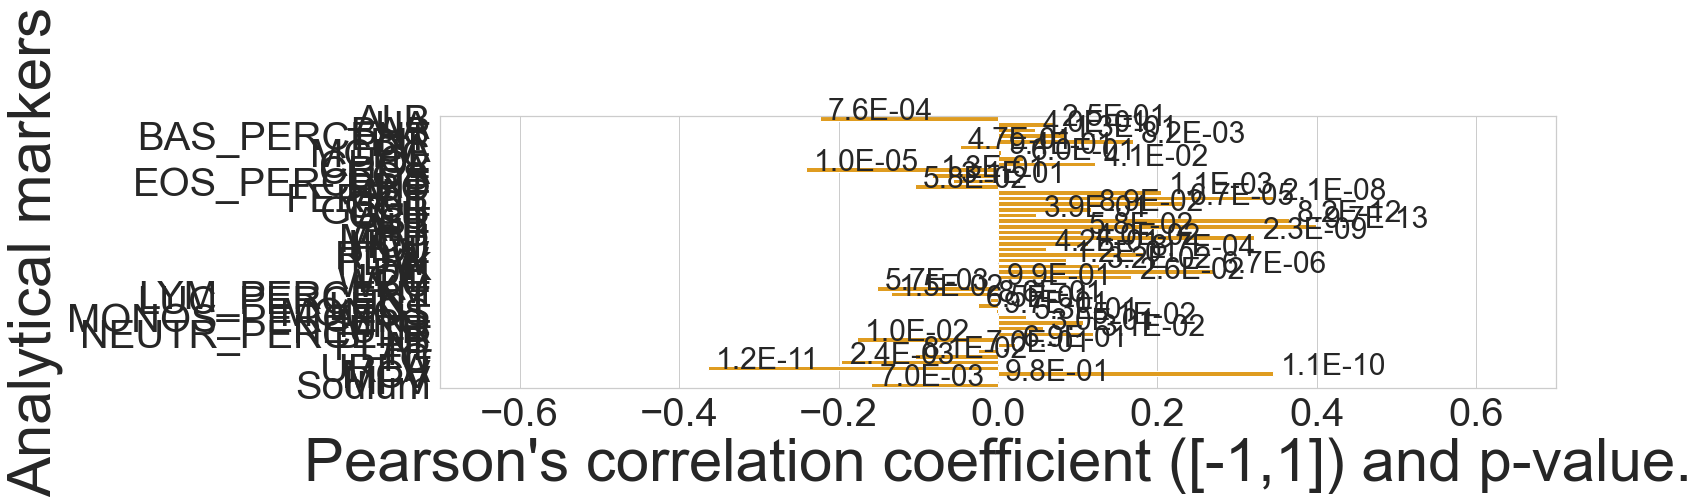

In [61]:

target='WEEKLY_SDU'
from matplotlib import interactive
interactive(True)
grafico_pearson(data=df,variables=v_analytics, var_target=target,y_label="Analytical markers")


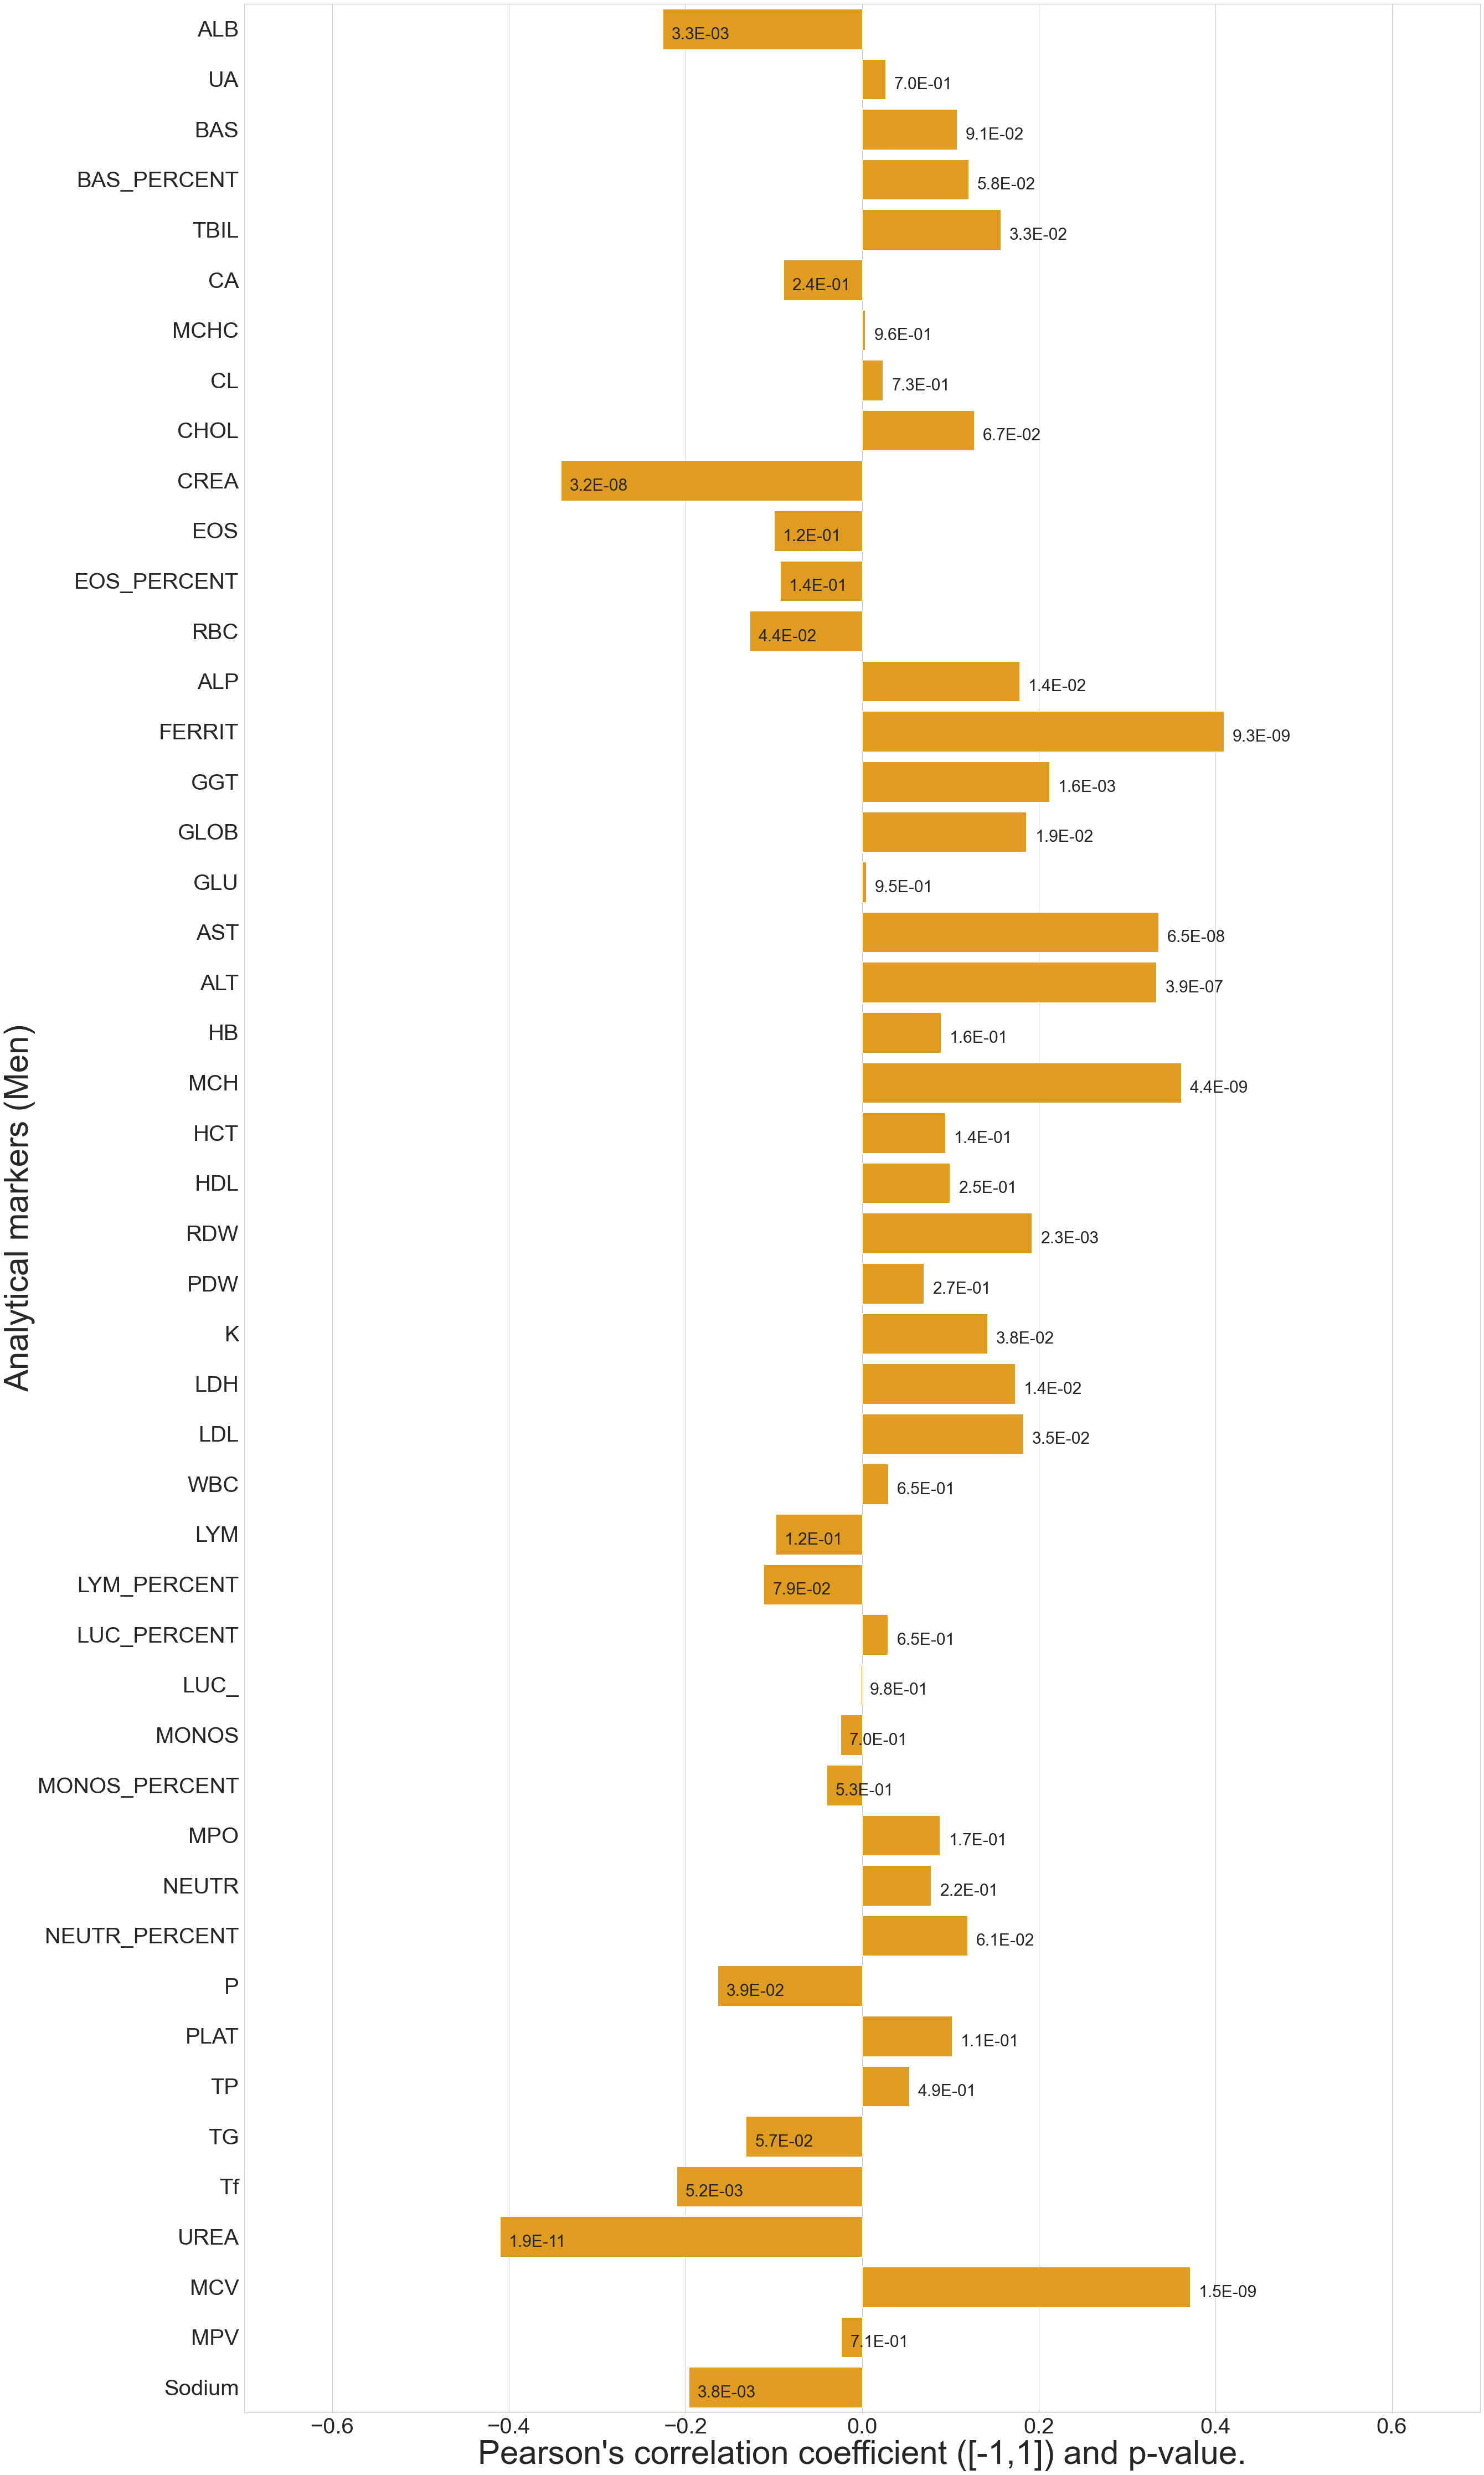

In [62]:
d=df[df['SEX']==1]

target='WEEKLY_SDU'
grafico_pearson(data=d,variables=v_analytics, var_target=target,y_label="Analytical markers (Men)")

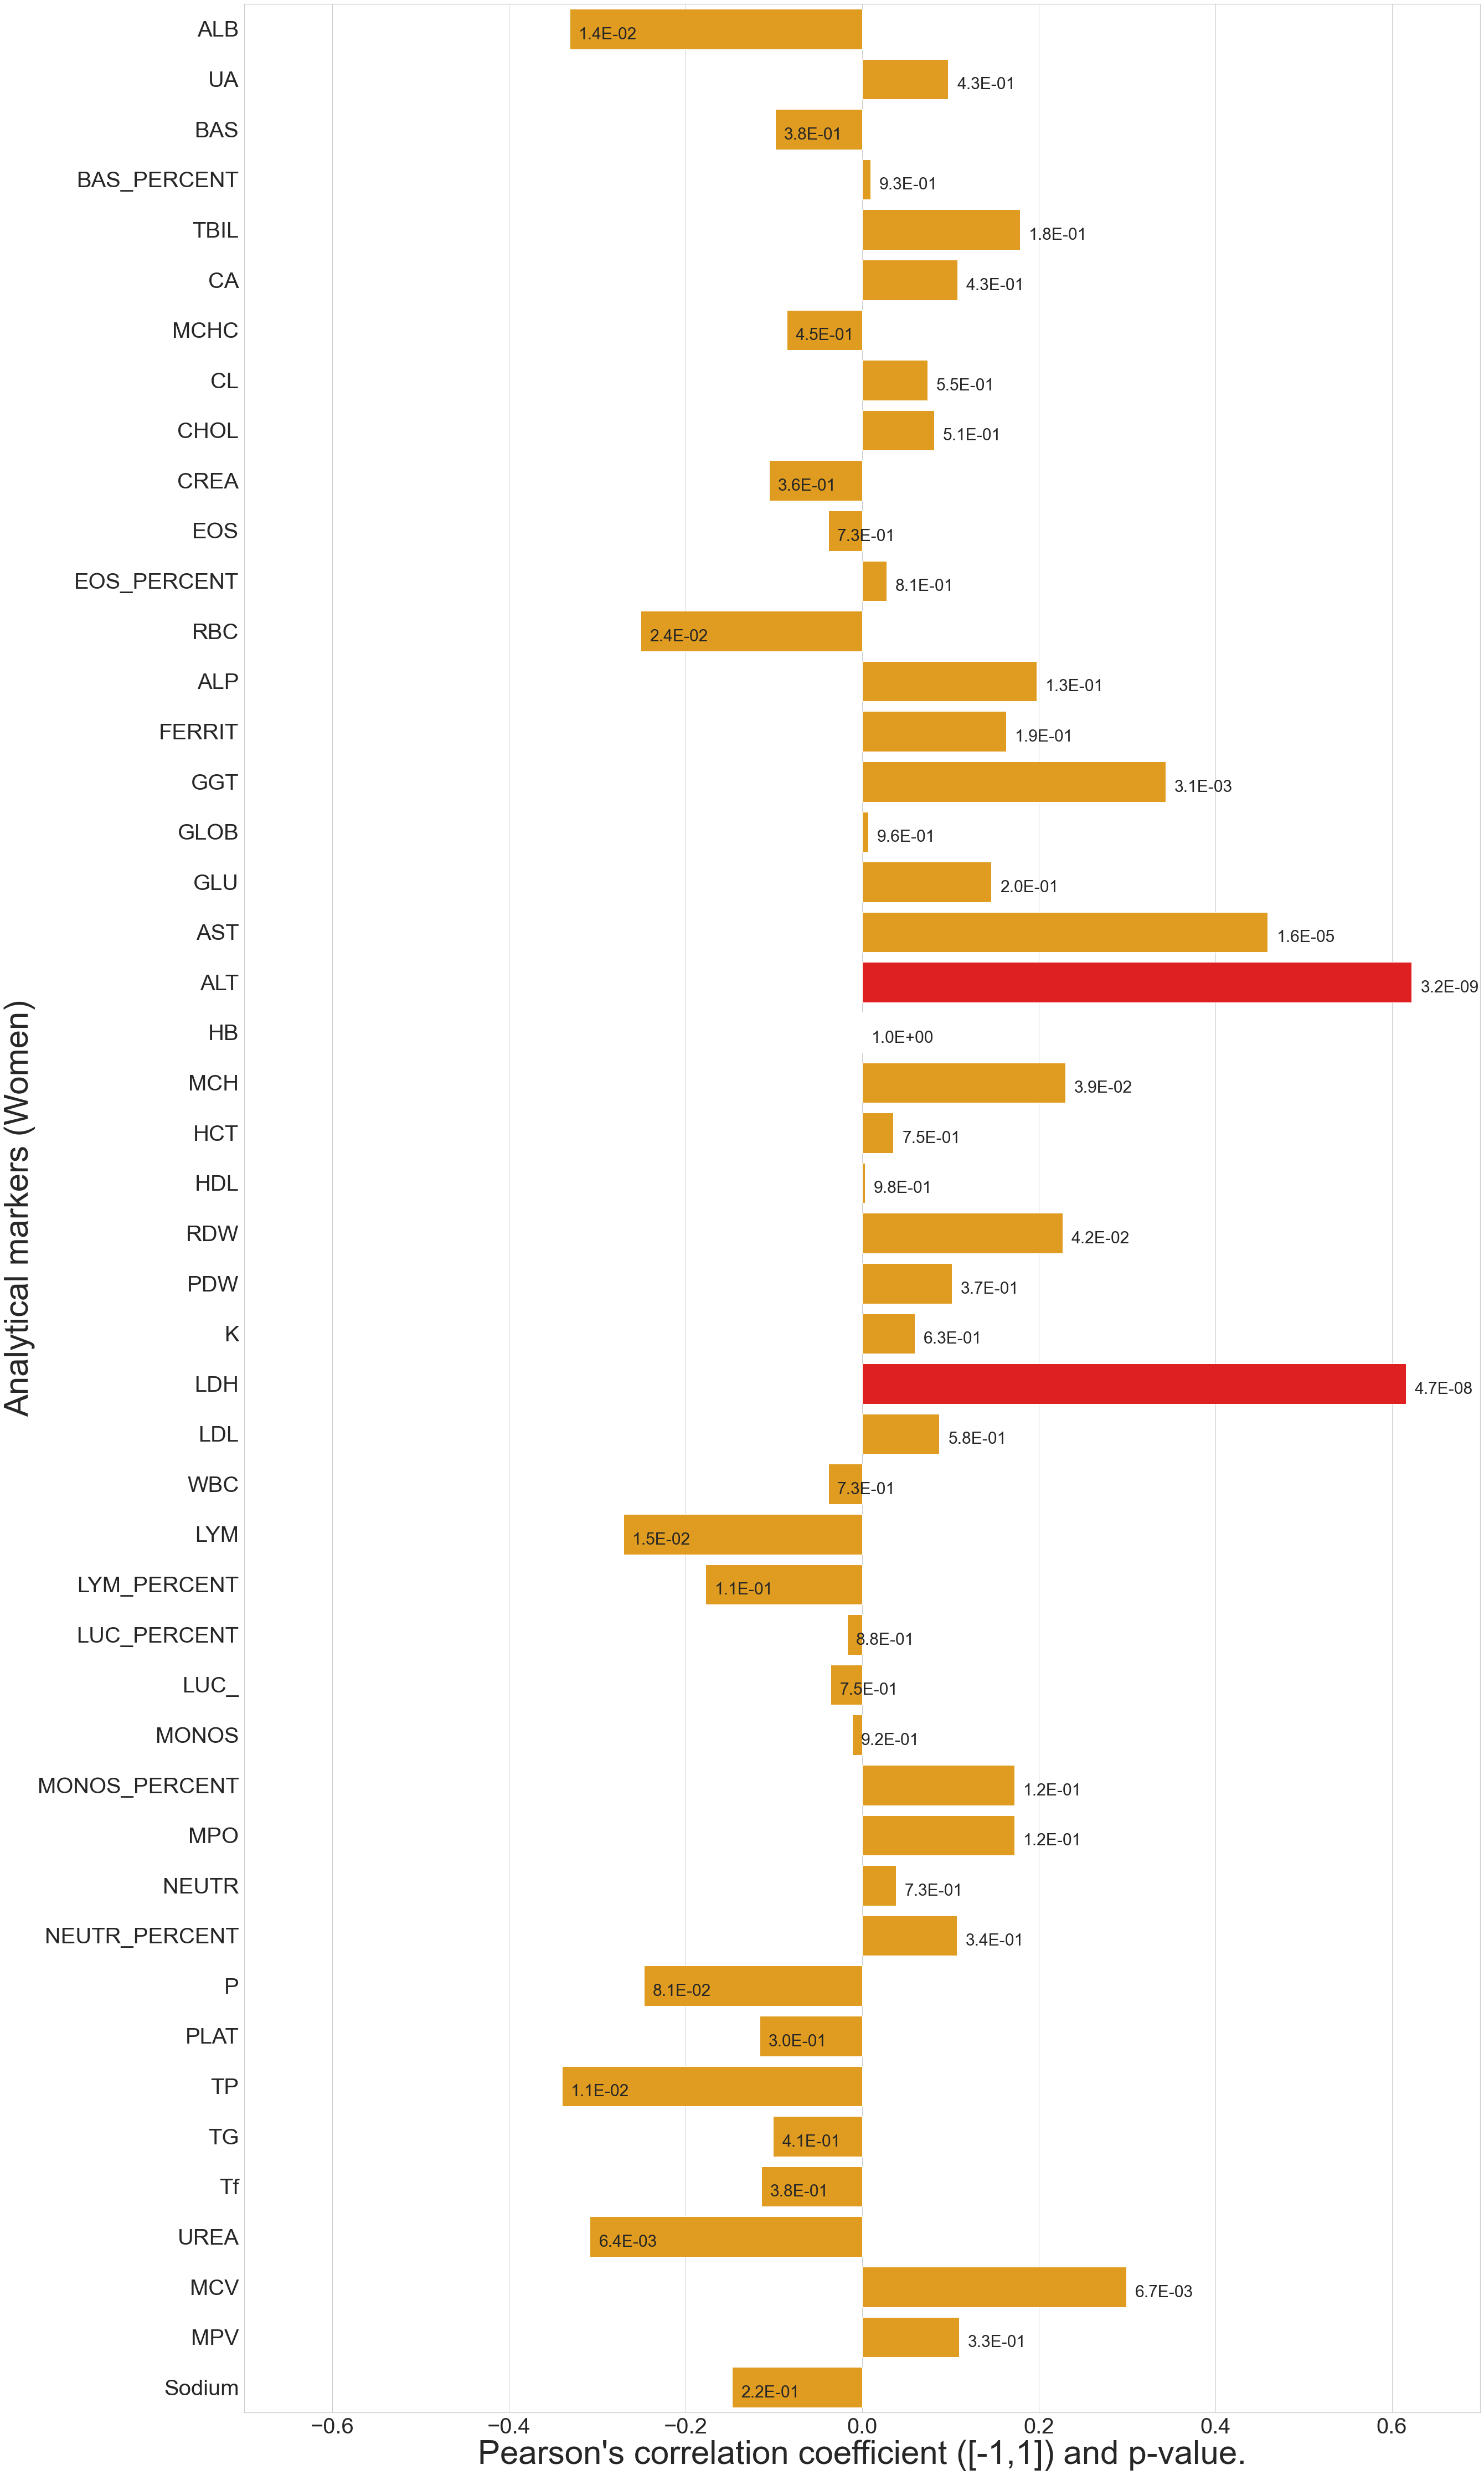

In [63]:
d=df[df['SEX']==2]
target='WEEKLY_SDU'
grafico_pearson(data=d,variables=v_analytics, var_target=target,y_label="Analytical markers (Women)")


### 1.B Con variable binomial Riesgo/no Riesgo
Compute if there exists difference between the average of each feature for Risk drinkers and not risk drinkers.
non parametric unparied Wilcoxon testl

In [64]:
def non_parametric_test_numericasvsfactor(dataframe,variables,factor,slots,labels,frecuencias):
    results=list()
    signif_indices=[]
    for j in range(len(variables)):
        results.append(variables[j])
        data=[]
        for v in slots:
            temp= dataframe[dataframe[factor]==v][variables[j]].values
            temp_no_nan=[val for val in temp if ~np.isnan(val)]
            
            m,left,right=mean_confidence_interval(temp_no_nan)
            results.append("{:.3f} [{:.3f},{:.3f}]".format(m,left,right))
            data = data + [list(temp_no_nan)]
        if len(slots)>2:
            p = kruskal(*data).pvalue
        else:
            if len(data)>1:
                #remove None values in list 
                _, p = ranksums(data[0], data[1])
            else: 
                p=1
        #mark = '' if p>=0.05 else '*'
        if p>=0.05:
            mark = ''
        else:
            mark = '*'
            signif_indices.append(j)
        p ="{:.2E}".format(p)+mark
        results.append(p)
    table = np.asmatrix(results)
    table=table.reshape(len(variables),len(slots)+2)
    col_names=[factor]
    for l in range(len(labels)):
        text = labels[l]+" (CI 95%)"
        col_names=col_names + [text]
    col_names=col_names + ["p-value"]
    table_df=pd.DataFrame(table,columns=[col_names])
    display(table_df)
    return signif_indices

#function to draw the values histogram, detect states with frequency<5, ans returns states with >=5.
def frecuencia_valores(dataframe,target,labels, MIN,rot=45):
    g=sns.catplot(x=target,data=dataframe,kind='count',order=range(len(labels)))
    if (MIN > 0): g.ax.axhline(MIN, ls='--')
    g.ax.set_xticklabels(labels,rotation=rot)
    valores_final=[]
    freqs=[]
    for v in range(len(labels)):
        N = len(dataframe[dataframe[target]==v].values)
        if N>=MIN:
            valores_final = valores_final + [v]
            freqs= freqs + [N]
    labels_final = [labels[x] for x in valores_final ]
    plt.show()
    return valores_final, labels_final, freqs

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

Averages difference for all cases.


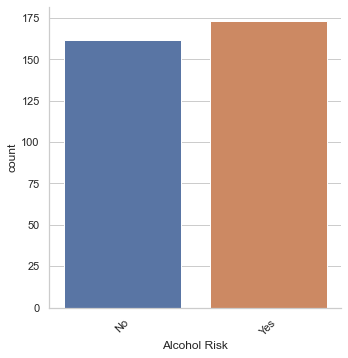

,Alcohol Risk,No (CI 95%),Yes (CI 95%),p-value
0,ALB,"4.745 [4.699,4.791]","4.465 [4.363,4.568]",2.94E-05*
1,UA,"5.336 [5.119,5.553]","5.400 [5.112,5.688]",9.77E-01
2,BAS,"0.038 [0.034,0.042]","0.042 [0.039,0.046]",1.68E-04*
3,BAS_PERCENT,"0.454 [0.415,0.493]","0.525 [0.481,0.568]",1.26E-01
4,TBIL,"0.449 [0.402,0.496]","0.660 [0.521,0.798]",7.21E-02
5,CA,"9.374 [9.317,9.431]","9.292 [9.173,9.411]",3.15E-01
6,MCHC,"33.170 [32.980,33.360]","33.363 [33.175,33.550]",1.56E-01
7,CL,"100.747 [100.373,101.121]","101.235 [100.552,101.918]",8.72E-02
8,CHOL,"192.468 [187.586,197.349]","206.144 [197.494,214.794]",1.70E-02*
9,CREA,"0.973 [0.941,1.005]","0.840 [0.811,0.868]",1.56E-09*


Average difference in men.


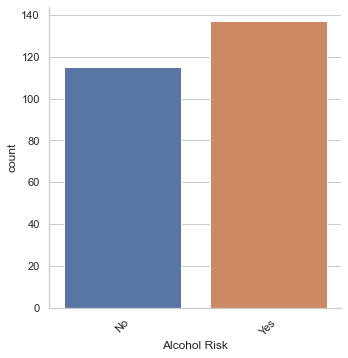

,Alcohol Risk,No (CI 95%),Yes (CI 95%),p-value
0,ALB,"4.759 [4.709,4.810]","4.523 [4.415,4.631]",8.87E-04*
1,UA,"5.770 [5.541,5.999]","5.659 [5.337,5.981]",3.00E-01
2,BAS,"0.034 [0.031,0.038]","0.044 [0.040,0.048]",5.53E-06*
3,BAS_PERCENT,"0.428 [0.385,0.471]","0.528 [0.478,0.577]",4.76E-02*
4,TBIL,"0.498 [0.441,0.554]","0.677 [0.510,0.843]",7.53E-01
5,CA,"9.384 [9.318,9.449]","9.306 [9.169,9.442]",3.46E-01
6,MCHC,"33.407 [33.192,33.622]","33.456 [33.258,33.654]",9.71E-01
7,CL,"100.609 [100.136,101.082]","101.208 [100.471,101.944]",7.10E-02
8,CHOL,"193.835 [187.769,199.901]","206.912 [197.483,216.341]",5.23E-02
9,CREA,"1.032 [0.998,1.067]","0.863 [0.833,0.892]",1.09E-12*


Average difference in women.


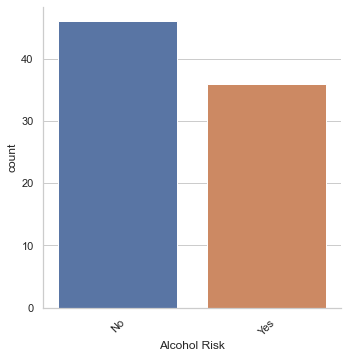

,Alcohol Risk,No (CI 95%),Yes (CI 95%),p-value
0,ALB,"4.693 [4.592,4.793]","4.213 [3.941,4.485]",6.70E-04*
1,UA,"4.144 [3.847,4.441]","4.364 [3.881,4.847]",4.01E-01
2,BAS,"0.046 [0.037,0.054]","0.037 [0.031,0.043]",9.36E-01
3,BAS_PERCENT,"0.507 [0.427,0.587]","0.514 [0.422,0.605]",9.58E-01
4,TBIL,"0.306 [0.245,0.367]","0.596 [0.370,0.822]",3.18E-03*
5,CA,"9.333 [9.215,9.452]","9.235 [8.985,9.485]",4.87E-01
6,MCHC,"32.558 [32.205,32.911]","33.017 [32.522,33.512]",2.92E-02*
7,CL,"101.116 [100.526,101.706]","101.346 [99.494,103.199]",8.43E-01
8,CHOL,"189.977 [181.736,198.218]","202.739 [179.612,225.866]",3.16E-01
9,CREA,"0.810 [0.761,0.859]","0.752 [0.675,0.829]",1.45E-02*


In [65]:
print("Averages difference for all cases.")
objetivo='Alcohol Risk'
labels = ['No','Yes']
slots_final,labels_final,frecuencias_final=frecuencia_valores(dataframe=df,target=objetivo,labels=labels,MIN=0)
signif_indices =  non_parametric_test_numericasvsfactor(dataframe=df,variables=v_analytics,factor=objetivo, 
                            slots=slots_final,labels=labels_final,frecuencias=frecuencias_final)

print("Average difference in men.")
data_hombres=df[df['SEX']==1]
slots_final,labels_final,frecuencias_final=frecuencia_valores(dataframe=data_hombres,target=objetivo,labels=labels,MIN=0)
signif_indices =  non_parametric_test_numericasvsfactor(dataframe=data_hombres,variables=v_analytics,factor=objetivo, 
                            slots=slots_final,labels=labels_final,frecuencias=frecuencias_final)


print("Average difference in women.")
data_hombres=df[df['SEX']==2]
slots_final,labels_final,frecuencias_final=frecuencia_valores(dataframe=data_hombres,target=objetivo,labels=labels,MIN=0)
signif_indices =  non_parametric_test_numericasvsfactor(dataframe=data_hombres,variables=v_analytics,factor=objetivo, 
                            slots=slots_final,labels=labels_final,frecuencias=frecuencias_final)

## Prediction

In [66]:
def print_report(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["No Risk","Risk"])
    plt.rcParams["figure.figsize"] = (5,5)
    disp.plot(include_values=True, cmap=plt.cm.Blues,values_format='.0f')
    plt.grid(False)


    # in binary classification, recall of the positive class is also known as “sensitivity”; 
    #recall of the negative class is “specificity”.
    tp_no = cm[0,0]
    fp_no = cm[1,0]
    sensibilidad_no = tp_no / (tp_no + fp_no)
    tp_si =cm[1,1]
    fp_si = cm[0,1]
    sensibilidad_si = tp_si / (tp_si + fp_si)
    print("Sensitivity: {:.3f}".format(sensibilidad_si))
    print("Specificity: {:.3f}".format(sensibilidad_no))
    print("FP_Risk:",fp_si)
    print("FN_Risk:",fp_no)
    

In [67]:
Y=df['Alcohol Risk'].values
counts = np.bincount(Y)
print(counts)
acc_baseline=counts[1]*100 / Y.shape[0]
print('Baseline: a classifier should perform at least with accuracy = {:.2f}%'.format(acc_baseline))

[162 173]
Baseline: a classifier should perform at least with accuracy = 51.64%


## 2 Logistic Regression
leave-one-out validation

In [68]:
from sklearn.linear_model import LogisticRegression

def logistic_clf(selected,listFP=False):
    
    X=df[selected]
    #create  dummy values
    if('SEX' in selected):
        sexo = pd.get_dummies(X['SEX'],drop_first=True,prefix='SEX')
        X= X.drop(['SEX'],axis=1)
        X = pd.concat([X,sexo],axis=1)
    
    Y=df['Alcohol Risk'].values
    accuracies = []

    loo = LeaveOneOut()
    # Impute  missing values with mean and normalize
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    pipe = Pipeline([('imp',imp), ('scaler', StandardScaler()), ('lr',LogisticRegression())])
    

    
    w, h = 2, 2
    conf_matrix = [[0 for x in range(w)] for y in range(h)]
    FP_IDs=[]
    for train_indices, test_indices in loo.split(X):
        X_t, X_T = X.values[train_indices], X.values[test_indices]
        Y_t, Y_T = Y[train_indices], Y[test_indices]
        pipe.fit(X_t,Y_t)
        accuracies.append(pipe.score(X_T,Y_T))
        y_pred=pipe.predict(X_T)
        y_prob=pipe.predict_proba(X_T)
        

        temp_matrix=confusion_matrix(Y_T, y_pred,labels=[0, 1])
        conf_matrix=temp_matrix+conf_matrix
        if(np.array_equal(np.array([[0, 1],[0, 0]]),temp_matrix)):
            id=X.iloc[test_indices].index[0]
            FP_IDs=FP_IDs+[id]
            
    print('Acc: {:.3f}  Std:{:.3f}'.format(np.mean(accuracies),np.std(accuracies)))

    print_report(cm=conf_matrix)
    if(listFP):
        print("FP (No Risk cases tagged as Risk) have the following ID ID, SEX and SDU:")
        display(df.loc[[f for f in FP_IDs]][['SEX','WEEKLY_SDU']])
    

    #compute model coefficients and check p-values
    pipe_rl = Pipeline([('imp',imp), ('scaler', StandardScaler())])
    col_names=X.columns
    X=pipe_rl.fit_transform(X)
    X=pd.DataFrame(data=X,columns=col_names)
    X=sm.add_constant(X)
    model = sm.Logit(Y, X)
    result = model.fit_regularized()
    print(result.summary())
    return result,FP_IDs,pipe_rl
    

Logistic regresssion using all analytical features:
Acc: 0.839  Std:0.368
Sensitivity: 0.844
Specificity: 0.833
FP_Risk: 27
FN_Risk: 27


c:\users\pablo.bermejo\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.22647153971509557
            Iterations: 375
            Function evaluations: 375
            Gradient evaluations: 375
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  335
Model:                          Logit   Df Residuals:                      283
Method:                           MLE   Df Model:                           51
Date:                Mon, 25 Oct 2021   Pseudo R-squ.:                  0.6730
Time:                        13:09:25   Log-Likelihood:                -75.868
converged:                       True   LL-Null:                       -232.02
Covariance Type:            nonrobust   LLR p-value:                 3.226e-39
                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

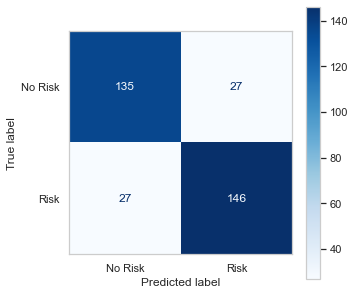

In [69]:
print("Logistic regresssion using all analytical features:")
cols =[c for c in df.columns if c not in ['CASES','WEEKLY_SDU','Alcohol Risk','LEVEL','MARITAL_STATUS']]
last_result,_,_ = logistic_clf(cols)
pvalues_last_model= last_result.pvalues

Logistic regression using only significant features:
const     0.029142
MCHC      0.033968
CL        0.004450
EOS       0.030947
ALP       0.012282
FERRIT    0.022192
MCH       0.004012
RDW       0.015148
K         0.045003
WBC       0.033873
LYM       0.035300
MONOS     0.017381
NEUTR     0.034736
UREA      0.002796
MCV       0.002027
Sodium    0.000515
dtype: float64
Acc: 0.851  Std:0.356
Sensitivity: 0.847
Specificity: 0.854
FP_Risk: 27
FN_Risk: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3229972437209298
            Iterations: 105
            Function evaluations: 105
            Gradient evaluations: 105
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  335
Model:                          Logit   Df Residuals:                      319
Method:                           MLE   Df Model:                           15
Date:          

c:\users\pablo.bermejo\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


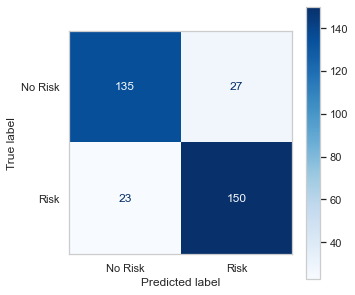

In [70]:
print("Logistic regression using only significant features:")
sig=pvalues_last_model[pvalues_last_model<0.05]
print(sig)
_,_,_=logistic_clf(sig.index[1:])

Logistic regression using selected features by algorithm IWSS: (previously run in its Weka version)
['ALB', 'MCH', 'GGT', 'BAS', 'P', 'AST', 'Tf', 'RDW', 'CHOL', 'CL', 'MPV', 'MONOS_PERCENT']
Acc: 0.821  Std:0.383
Sensitivity: 0.834
Specificity: 0.807
FP_Risk: 28
FN_Risk: 32
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3975119128329304
            Iterations: 57
            Function evaluations: 57
            Gradient evaluations: 57
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  335
Model:                          Logit   Df Residuals:                      322
Method:                           MLE   Df Model:                           12
Date:                Mon, 25 Oct 2021   Pseudo R-squ.:                  0.4261
Time:                        13:09:30   Log-Likelihood:                -133.17
converged:                       True   

c:\users\pablo.bermejo\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


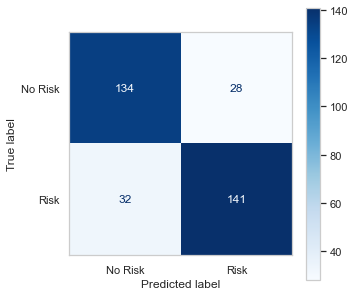

In [71]:
print("Logistic regression using selected features by algorithm IWSS: (previously run in its Weka version)")
log_IWSS = ['ALB','MCH','GGT','BAS','P','AST','Tf','RDW','CHOL','CL','MPV','MONOS_PERCENT']

print(log_IWSS)
_,_,_=logistic_clf(log_IWSS)

Logistic regression using selected features by algorithm IWSSr: (previously run in its Weka version)
['MCH', 'GGT', 'RDW', 'CREA', 'TBIL', 'MPV', 'LUC_', 'HDL']
Acc: 0.848  Std:0.359
Sensitivity: 0.863
Specificity: 0.832
FP_Risk: 23
FN_Risk: 28
FP (No Risk cases tagged as Risk) have the following ID ID, SEX and SDU:


,SEX,WEEKLY_SDU
ID,,
8,1.0,10.0
16,1.0,27.0
43,1.0,15.0
48,2.0,15.0
61,1.0,21.0
65,1.0,15.0
66,1.0,15.0
74,2.0,16.0
76,2.0,15.0


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.40900734423066887
            Iterations: 50
            Function evaluations: 50
            Gradient evaluations: 50
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  335
Model:                          Logit   Df Residuals:                      326
Method:                           MLE   Df Model:                            8
Date:                Mon, 25 Oct 2021   Pseudo R-squ.:                  0.4095
Time:                        13:09:33   Log-Likelihood:                -137.02
converged:                       True   LL-Null:                       -232.02
Covariance Type:            nonrobust   LLR p-value:                 8.095e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

c:\users\pablo.bermejo\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


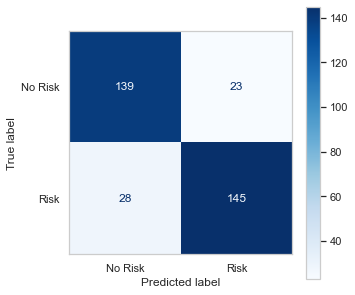

In [72]:
print("Logistic regression using selected features by algorithm IWSSr: (previously run in its Weka version)")
log_IWSSr = ['MCH','GGT','RDW','CREA','TBIL','MPV','LUC_','HDL']

print(log_IWSSr)
last_result_IWSSr, lastFP,pipe_rl=logistic_clf(log_IWSSr,listFP=True)

In [73]:
params = last_result_IWSSr.params
conf = last_result_IWSSr.conf_int()
conf['OR'] = params
cols= ['2.5%', '97.5%', 'OR']
conf.columns =cols
cols = cols[-1:] + cols[:-1]
conf = conf[cols]
print(np.exp(conf))

              OR      2.5%      97.5%
const   2.029667  1.300970   3.166521
MCH     3.927028  2.571032   5.998193
GGT    16.119496  3.041074  85.442877
RDW     2.902929  1.940129   4.343525
CREA    0.478503  0.336430   0.680574
TBIL    1.639260  0.841488   3.193356
MPV     0.834910  0.619321   1.125546
LUC_    1.504434  0.391252   5.784825
HDL     0.508641  0.335043   0.772187


Here we show the list of FP predicted by the regression model created with features from IWSSr,
and we also showh IDs of patients from the Adictive Behaviour Unit (UCA) which were tagged as No Risk
based on the rule shown at start of this analysis.


In [74]:
uca_no_riesgo=df[(df['CASES']==1) & (df['Alcohol Risk']==0)].index.values
FP_RL_IWSSr=lastFP
print("FP_LR_iwssr:",FP_RL_IWSSr)
print("UCA No Risk:",uca_no_riesgo)
coincidentes_rl=list(set(FP_RL_IWSSr) & set(uca_no_riesgo))
print("{:d} Coincidences among  {:d} FP:".format(len(coincidentes_rl),len(FP_RL_IWSSr)),coincidentes_rl)


FP_LR_iwssr: [8, 16, 43, 48, 61, 65, 66, 74, 76, 87, 116, 131, 176, 184, 256, 266, 279, 287, 300, 303, 308, 320, 322]
UCA No Risk: [  8  16  19  20  23  34  39  43  48  53  61  62  65  66  74  76  87  92
 116 124 128 131 147 164 165 176 184 189 196]
14 Coincidences among  23 FP: [65, 66, 131, 8, 74, 43, 76, 16, 48, 176, 116, 87, 184, 61]


----------------------
#### Manual use of the model to make a prediction
As an example, we choose case ID=1 and we use its feature values in equation:
$Prob(Risk) = 1 / (1 + exp(-Z))$, where $Z$ is the sum of each variable multiplied by its corresponding coefficient.
Since the training set was scaled, before making the prediction in new cases we have to scale them using the same learned 
mean and deviation for each feature.
Thaus, $scaled\_value_{X_i} = (value_{X_i} - mean_{X_i})deviation_{X_i}$

In [75]:

show_df=pd.DataFrame()
show_df['Value']=df.loc[1][log_IWSSr]


show_df['Mean']=pipe_rl['scaler'].mean_
show_df['Std.Dev']=pipe_rl['scaler'].var_**(1/2)
show_df['Scale']=(show_df['Value']-show_df['Mean']) / show_df['Std.Dev']
display(show_df)

,Value,Mean,Std.Dev,Scale
MCH,31.20,31.055589,2.445915,0.059042
GGT,48.00,85.000000,209.236038,-0.176834
RDW,14.30,13.862840,1.546930,0.282598
CREA,0.97,0.903517,0.203253,0.327096
TBIL,0.30,0.547737,0.472864,-0.523906
MPV,9.20,9.470393,1.169194,-0.231264
LUC_,0.20,0.183927,0.287767,0.055853
HDL,36.00,59.043716,17.241018,-1.336564


$Z = 0.6778 + 1.2997*0.059042 - 2.8804*0.176834 + 0.9826*0.282598  + 0.7294*0.327096 - 0.5458*0.523906 -0.1743*0.231264 + 0.105*0.055853 - 0.7287*1.336564 = 1.01846$

$prob(risk) = 1 / (1 + exp(-1.01846)) = 0.73467 $

Since prob(risk)>0.5 (standard threshold), prediction is Risk. This is a TP since patient with ID=1 is indeed a Risk patitent.



## 2. Classification tree

In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz 
import pydotplus
import matplotlib.image as mpimg
import io
from sklearn.tree import DecisionTreeClassifier, plot_tree

def tree_clf(selected,listFP=False):

    X=df[selected]
    #stydies and civil state are removed since those features have too many levels

     
    Y=df['Alcohol Risk']
    accuracies = []

    depth=5
    loo = LeaveOneOut()
    clf = DecisionTreeClassifier(criterion="entropy",max_depth=depth,random_state=1)
    # impute and normalize
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    pipe = Pipeline([('imp',imp), ('clf',clf)])

    
    w, h = 2, 2
    conf_matrix = [[0 for x in range(w)] for y in range(h)]
    FP_IDs=[]
    for train_indices, test_indices in loo.split(X):
        X_t, X_T = X.values[train_indices], X.values[test_indices]
        Y_t, Y_T = Y.values[train_indices], Y.values[test_indices]
        pipe.fit(X_t,Y_t)
        accuracies.append(pipe.score(X_T,Y_T))
        y_pred=pipe.predict(X_T)
        
        
        temp_matrix=confusion_matrix(Y_T, y_pred,labels=[0, 1])
        conf_matrix=temp_matrix+conf_matrix
        if(np.array_equal(np.array([[0, 1],[0, 0]]),temp_matrix)):
            id=X.iloc[test_indices].index[0]
            FP_IDs=FP_IDs+[id]
        
    print('Acc: {:.4f}  Std:{:.4f}'.format(np.mean(accuracies),np.std(accuracies)))
    print_report(cm=conf_matrix)
    
    
    if(listFP):
        print("FPs are:")
        display(df.loc[[f for f in FP_IDs]][['SEX','WEEKLY_SDU']])
    
    
    pipe.fit(X,Y)
    
    
    tree.export_graphviz(clf, out_file="tree.dot",  class_names=["No Risk","Risk"],
                    feature_names=selected, impurity=False, filled=True)
    with open("tree.dot") as f:
        dot_graph = f.read()
    g = graphviz.Source(dot_graph)
    
    g.view()
    
    
    return FP_IDs

  

Acc: 0.7940  Std:0.4044
Sensitivity: 0.813
Specificity: 0.775
FP_Risk: 31
FN_Risk: 38


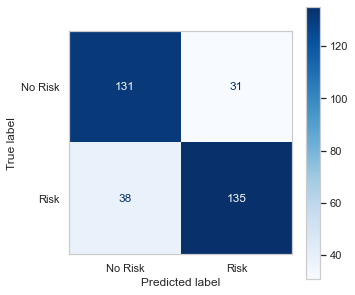

In [77]:
#run 'dot -Tsvg tree.dot -o tree.svg' in analysis folder to get tree in .svg format

cols =[c for c in df.columns if c not in ['CASES','WEEKLY_SDU','Alcohol Risk','STUDY_LEVEL','MARITAL_STATUS']]
fp_tree=tree_clf(selected=cols,listFP=False)

In [78]:
uca_no_riesgo=df[(df['CASES']==1) & (df['Alcohol Risk']==0)].index.values
print("FP_tree_:",fp_tree)
print("UCA No Risl:",uca_no_riesgo)

coincidentes_tree=list(set(uca_no_riesgo) & set(fp_tree))
print("{:d} Coincidences between {:d} FPs and {:d} patients from UCA tagges as NO RIESGO:".format(len(coincidentes_tree),len(fp_tree),len(uca_no_riesgo)),coincidentes_tree)


coincidentes_tree_rl=list(set(lastFP) & set(fp_tree))
print("\n{:d} Coincidences between {:d} FP from tree and {:d} FP from last logistic regression:".format(len(coincidentes_tree_rl),len(fp_tree),len(FP_RL_IWSSr)))
print("Same FPs in tree and logistic regression:",coincidentes_tree_rl)

FP_tree_: [8, 16, 20, 43, 48, 53, 61, 62, 65, 74, 76, 92, 116, 128, 131, 147, 165, 176, 184, 196, 221, 228, 244, 249, 257, 263, 267, 287, 296, 321, 327]
UCA No Risl: [  8  16  19  20  23  34  39  43  48  53  61  62  65  66  74  76  87  92
 116 124 128 131 147 164 165 176 184 189 196]
20 Coincidences between 31 FPs and 29 patients from UCA tagges as NO RIESGO: [128, 131, 8, 16, 147, 20, 165, 43, 48, 176, 53, 184, 61, 62, 65, 196, 74, 76, 92, 116]

13 Coincidences between 31 FP from tree and 23 FP from last logistic regression:
Same FPs in tree and logistic regression: [65, 131, 8, 74, 43, 76, 16, 48, 176, 116, 184, 61, 287]


Acc: 0.7940  Std:0.4044
Sensitivity: 0.813
Specificity: 0.775
FP_Risk: 31
FN_Risk: 38


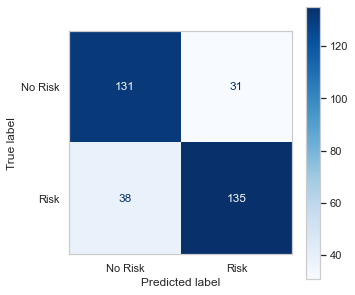

In [79]:
#run 'dot -Tsvg tree.dot -o tree.svg' in analysis folder to get tree in .svg format

cols =[c for c in df.columns if c not in ['CASES','WEEKLY_SDU','Alcohol Risk','STUDY_LEVEL','MARITAL_STATUS']]
fp_tree=tree_clf(selected=cols,listFP=False)

In [80]:
uca_no_riesgo=df[(df['CASES']==1) & (df['Alcohol Risk']==0)].index.values
print("FP_tree_:",fp_tree)
print("UCA No Risl:",uca_no_riesgo)

coincidentes_tree=list(set(uca_no_riesgo) & set(fp_tree))
print("{:d} Coincidences between {:d} FPs and {:d} patients from UCA tagged as NO Risk:".format(len(coincidentes_tree),len(fp_tree),len(uca_no_riesgo)),coincidentes_tree)


coincidentes_tree_rl=list(set(lastFP) & set(fp_tree))
print("Same FPs in tree and logistic regression:",coincidentes_tree_rl)





FP_tree_: [8, 16, 20, 43, 48, 53, 61, 62, 65, 74, 76, 92, 116, 128, 131, 147, 165, 176, 184, 196, 221, 228, 244, 249, 257, 263, 267, 287, 296, 321, 327]
UCA No Risl: [  8  16  19  20  23  34  39  43  48  53  61  62  65  66  74  76  87  92
 116 124 128 131 147 164 165 176 184 189 196]
20 Coincidences between 31 FPs and 29 patients from UCA tagged as NO Risk: [128, 131, 8, 16, 147, 20, 165, 43, 48, 176, 53, 184, 61, 62, 65, 196, 74, 76, 92, 116]
Same FPs in tree and logistic regression: [65, 131, 8, 74, 43, 76, 16, 48, 176, 116, 184, 61, 287]


## 3. Bayesian Network

In [54]:
#save current ddbb in arff (Weka) format
df2=df.copy()
print(df.columns)
df2.reset_index(level=0, inplace=True) #index is now column ID
#print(df2["STUDY_LEVEL"]==-1)
from pandas2arff import pandas2arff
#you need to create folder wekaClassification or any other before running next line
pandas2arff(df2, "../wekaClassification/pandas_alcohol.arff", wekaname="pandasdata", cleanstringdata=True, cleannan=True)

Index(['CASES', 'STUDY_LEVEL', 'MARITAL_STATUS', 'SEX', 'AGE', 'ALB', 'UA',
       'BAS', 'BAS_PERCENT', 'TBIL', 'CA', 'MCHC', 'CL', 'CHOL', 'CREA', 'EOS',
       'EOS_PERCENT', 'RBC', 'ALP', 'FERRIT', 'GGT', 'GLOB', 'GLU', 'AST',
       'ALT', 'HB', 'MCH', 'HCT', 'HDL', 'RDW', 'PDW', 'K', 'LDH', 'LDL',
       'WBC', 'LYM', 'LYM_PERCENT', 'LUC_PERCENT', 'LUC_', 'MONOS',
       'MONOS_PERCENT', 'MPO', 'NEUTR', 'NEUTR_PERCENT', 'P', 'PLAT', 'TP',
       'TG', 'Tf', 'UREA', 'MCV', 'MPV', 'Sodium', 'WEEKLY_SDU',
       'Alcohol Risk'],
      dtype='object')


True

Sensitivity: 0.883
Specificity: 0.866
FP_Risk: 20
FN_Risk: 22


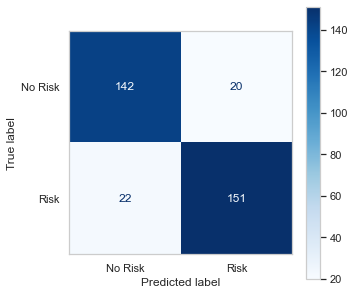

In [81]:
#Results obtained from Weka wusing pandas_alcohol.arff
np.matrix
print_report(cm=np.matrix([[142,20],[22,151]]))

In [82]:
uca_no_riesgo=df[(df['CASES']==1) & (df['Alcohol Risk']==0)].index.values

lastFP=[165, 234,124,8,76,19,293,92,48,131,43,249,147,16,65,128,61,116,184,209]
print("FP_bayesnet_iwss:",lastFP)
print("UCA No Risk:",uca_no_riesgo)
coincidentes_bn=list(set(lastFP) & set(uca_no_riesgo))
print("{:d} Coincidences among {:d} FP:".format(len(coincidentes_rl),len(lastFP)),coincidentes_bn)

FP_bayesnet_iwss: [165, 234, 124, 8, 76, 19, 293, 92, 48, 131, 43, 249, 147, 16, 65, 128, 61, 116, 184, 209]
UCA No Risk: [  8  16  19  20  23  34  39  43  48  53  61  62  65  66  74  76  87  92
 116 124 128 131 147 164 165 176 184 189 196]
14 Coincidences among 20 FP: [128, 65, 131, 165, 8, 43, 76, 16, 48, 124, 19, 147, 116, 184, 92, 61]


In [83]:
uca_no_riesgo=df[(df['CASES']==1) & (df['Alcohol Risk']==0)].index.values
lastFP=[8,16,19,39,43,48,53,61,66,74,76,87,92,124,131,147,184,194, 165,228]
print("FP_bayes_iwss:",lastFP)
print("UCA No Risk:",uca_no_riesgo)
coincidentes_bn=list(set(lastFP) & set(uca_no_riesgo))
print("{:d} Coincidences among {:d} FP:".format(len(coincidentes_rl),len(lastFP)),coincidentes_bn)

FP_bayes_iwss: [8, 16, 19, 39, 43, 48, 53, 61, 66, 74, 76, 87, 92, 124, 131, 147, 184, 194, 165, 228]
UCA No Risk: [  8  16  19  20  23  34  39  43  48  53  61  62  65  66  74  76  87  92
 116 124 128 131 147 164 165 176 184 189 196]
14 Coincidences among 20 FP: [66, 131, 165, 39, 8, 74, 43, 76, 16, 48, 124, 147, 19, 53, 87, 184, 92, 61]


In [84]:
import math
show_df=pd.DataFrame()
bayesnet_IWSS=['STUDY_LEVEL', 'BAS', 'CREA', 'ALP', 'GGT', 'MCH', 'HCT', 'RDW', 'LDH', 'UREA']

show_df['Value']=df.loc[1][bayesnet_IWSS]

display(show_df)

,Value
STUDY_LEVEL,2.00
BAS,0.04
CREA,0.97
ALP,101.00
GGT,48.00
MCH,31.20
HCT,50.50
RDW,14.30
LDH,204.00
UREA,35.00


In [85]:
import math
show_df=pd.DataFrame()
bayesnet_IWSS=['STUDY_LEVEL', 'BAS', 'CREA', 'ALP', 'GGT', 'MCH', 'HCT', 'RDW', 'LDH', 'UREA']

show_df['Value']=df.loc[1][bayesnet_IWSS]

display(show_df)

,Value
STUDY_LEVEL,2.00
BAS,0.04
CREA,0.97
ALP,101.00
GGT,48.00
MCH,31.20
HCT,50.50
RDW,14.30
LDH,204.00
UREA,35.00
